# Issues need to be solved:
1. Potential array interpolation.

    For a 3-dimensional interpolation, there could be also **_nearest_, _linear_ and _cubic_** methods. [Wiki on multivariate interpolation.](https://en.wikipedia.org/wiki/Interpolation)  [Scipy.interpolate](https://docs.scipy.org/doc/scipy-0.18.1/reference/interpolate.html) provides several functions for high dimension interpolation. [RegularGridInterpolation](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.RegularGridInterpolator.html#scipy.interpolate.RegularGridInterpolator) only provides linear and nearest methods, which might be insufficient for our field potential interpolation. [GridData function](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata) provides (1-d or 2-d) cubic interpolation, which might match our request.
    
2. Units.

    In the trajectory calculation, length in unit of mm, time in unit of us, velocity in unit of mm/us, charge in unit of e, mass in unit of atomic unit mass 
    
3. Trajectories iteration or 2nd [ODE solution](https://docs.scipy.org/doc/scipy-0.13.0/reference/integrate.html)
    
    [ode](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode)
    
    [odein](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.integrate.odeint.html)
    
    Vector function integration using [Runge-Kutta methods](https://rosettacode.org/wiki/Runge-Kutta_method) or Euler
    Should the gradient force be calculated everytime iteration is made or should it be calculated at once.
    
    
## To-Do
1. Integration method problem. [Change iteration algorithms](http://stackoverflow.com/questions/19779217/need-help-solving-a-second-order-non-linear-ode-in-python)
Runge-Kutta method?

2. Interpolation and gradient calculation step.

3. Change electrodes potentials to the current setup. Single ion trajectory as function of time. in Runge-Kutta integration.

4. Simulate detected signal.

5. Time resolution

6. Define MCP detection area and ion stop condition

11.08: When doing Gradient/Electric force calculation, spatial step is important

### Import potentials and coordinates from HDF5 file

In [1]:
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import RegularGridInterpolator as rgi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import time

In [2]:
#Potential field are stored in a HDF5 file
f=h5py.File('PA_v4.hdf5','r')

In [3]:
for name in f:
    print name

Coordinates
Potential Arrays
iselectrode


In [4]:
#coordinates x,y,z in unit of mm
x=f["Coordinates/X"].value/2.
y=f["Coordinates/Y"].value/2.
z=f["Coordinates/Z"].value/2.

### Set electrodes potentials and calculate spatial potential values
19 electrodes are set to certain potentials to create electric field to ionize Rydberg atoms

In [5]:
#set values of 19 electrodes, for ionization field of state n=30
#electrode_set_potentials=[187.*1.2,187.*1.2,-1.74,-278.*1.2,-0.114*1.2,-1900.,0.,3.97*1.2,-1.74*1.2,-278.*1.2,187.*1.2,187.*1.2,0.3*1.2,-278.*1.2,0.,0.,0.,0.318*1.2,0.307*1.2];
electrode_set_potentials=[195.,195.,-145.,-232.,-0.114,-1900.,0.,4.,0.3,-232.,195.,195.,-145.,-232.,0.,0.,0.,0.318,0.307];

In [6]:
# generate potential by setting each electrode to its potential and adding up all electrodes' potential
potentials=np.zeros((len(x),len(y),len(z)))
for i in range(19):
    electroden=f["Potential Arrays/electrode"+str(i+1)].value
    potentials+=electrode_set_potentials[i]*electroden/10000.

### Interpolate potential arrays and plot cross sections for comparison

In [7]:
#generate potential interpolation

from scipy.interpolate import RegularGridInterpolator as rgi
p_interpolation=rgi((x,y,z),potentials)

#### MCP detector plane

In [8]:
mx=np.arange(-8,8,0.1)
my=np.arange(-8,8,0.1)

points=np.array([])

for i in mx:
    for j in my:
        if (i**2+j**2)<= 7.25**2:
            points=np.append(points,([i,j,3]))

points=points.reshape((len(points)/3,3))

phi=-82.*np.pi/180.
tmatrix=np.array([[np.cos(phi),0,-np.sin(phi)],
           [0,1,0],
           [np.sin(phi),0,np.cos(phi)]])

MCPgrid=np.array([tmatrix.dot(i) for i in points])*2 + [247,205,214]
MCP=MCPgrid/2

In [9]:
#center point of MCP plane
center=(tmatrix.dot(np.array([0.,0.,3.]))*2 + [247,205,214])/2
#c=(241+6*np.cos(phi) + np.tan(- phi)*(247 + 6*np.sin( - phi)))/2.
c=center[2] + np.tan(- phi)* center[0]
center, c

(array([ 126.47080421,  102.5       ,  107.4175193 ]), 1007.3040503174313)

<IPython.core.display.Javascript object>


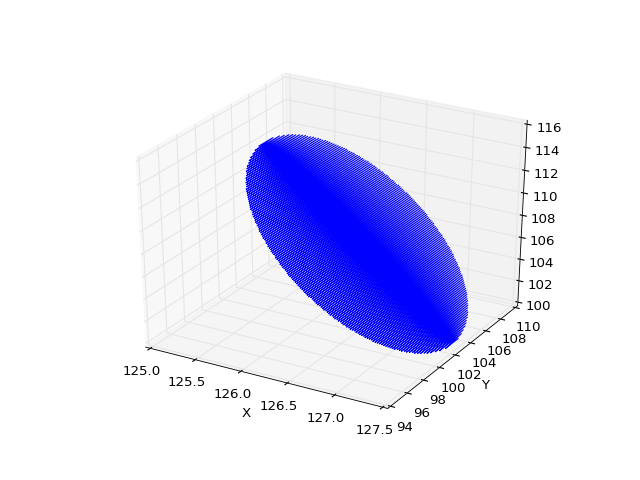

In [10]:
%matplotlib notebook
mcpplot=plt.figure()
mp=mcpplot.add_subplot(111,projection='3d')
mp.plot(MCP[:,0],MCP[:,1],MCP[:,2],label='MCP')
#mp.plot(points[:,0],points[:,1],points[:,2])
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

#### Define functions for single ion calculation

In [10]:
#single ion's position and velocity iteration functions

def R(ri,vi,dt):                  #delta_t in unit of micro-second, displacement in unit of mm, v in unit of mm/us
    x_new=ri[0]+vi[0]*dt
    y_new=ri[1]+vi[1]*dt
    z_new=ri[2]+vi[2]*dt
    return np.array([x_new,y_new,z_new])

def V(ri,vi,delta_t,dr):
    dvx=-100./(1.0364*87.) * (p_interpolation([ri[0]+dr,ri[1],ri[2]])[0]-p_interpolation([ri[0]-dr,ri[1],ri[2]])[0])/(dr*2) #- for positive ions, + for electrons
    dvy=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1]+dr,ri[2]])[0]-p_interpolation([ri[0],ri[1]-dr,ri[2]])[0])/(dr*2)
    dvz=-100./(1.0364*87.) * (p_interpolation([ri[0],ri[1],ri[2]+dr])[0]-p_interpolation([ri[0],ri[1],ri[2]-dr])[0])/(dr*2)
    vx_new=vi[0]+dvx * dt
    vy_new=vi[1]+dvy * dt
    vz_new=vi[2]+dvz * dt
    return np.array([vx_new,vy_new,vz_new])

def VCoul(ra,rb):
    #coulombic acceleration of Rb ion at ra, due to repulsion of Rb ion at rb
    distance=np.linalg.norm(ra-rb)
    coulf=1.595 * 1.e-6 /distance**2
    return (ra-rb)*coulf/distance
    

def cross_ratio(r_n,r_iter,count,dt):
    x1=r_n[0]
    z1=r_n[2]
    x2=r_iter[0]
    z2=r_iter[2]
    a=np.array([[np.tan(-phi),1.],[(z2-z1)/(x1-x2),1]])
    b=np.array([c,(x1*z2-x2*z1)/(x1-x2)])
    
    r_p= np.linalg.solve(a,b)
    ratio=(r_p[0]-r_n[0])/(r_iter[0]-r_n[0])
    count += ratio
    y_p= r_n[1] +(r_iter[1]-r_n[1])*ratio
    t=count*dt
    r_new= [np.sign(r_p[1]-center[2]) * np.sqrt((r_p[0]-center[0])**2 + (r_p[1]-center[2])**2),y_p-center[1],t]
    return r_new



def nstop(r):
    xx=r[0]
    zz=r[2]
    if (zz+np.tan(phi)*xx)< c :
        return True
    else:
        return False

**Distance step when calculating gradient has significant fluence on the trajectories**

In [11]:
dr=0.5       #dr[mm] is used when calculating gradients
dt=0.01     #dt[us]
v0=np.array([0,0,0])

In [12]:
def trajectory(r_init,v_init,dt):
    #calculate single ion trajectory and record each step
    v_iter=np.zeros((1,3))
    r_iter=np.zeros((1,3))
    r_iter[0]=r_init
    v_iter[0]=v_init 
    count=0              #no appending?
    while (r_iter[-1]>[x[1],y[1],z[1]]).all() and (r_iter[-1]<[x[-2],y[-2],z[-2]]).all() and (r_iter[-1][2]-np.tan(phi)*r_iter[-1][0]<=c):
        # while loop condition: ion still in effective volume, and not hit the plane
        v_iter=np.append(v_iter,[V(r_iter[-1],v_iter[-1],dt,dr)],0)
        r_iter=np.append(r_iter,[R(r_iter[-1],v_iter[-1],dt)],0)
        count+=1
        if count*dt>20:
            break
        
    r=r_iter
    v=v_iter
    t=len(r_iter)*dt
    return [r,v,t]

def trajectory2(r_init,v_init,dt):
    #calculate single ion trajectory and record only final point. Final points is cross point of last two points and MCP detection plane
    r_iter=r_init
    v_iter=v_init 
    r_n=r_init
    count=0              #no appending?
    while (r_iter>[x[1],y[1],z[1]]).all() and (r_iter<[x[-2],y[-2],z[-2]]).all() and (r_iter[2]-np.tan(phi)*r_iter[0]<=c):
        # while loop condition: ion still in effective volume, and not hit the plane
        r_n=r_iter
        v_iter=V(r_iter,v_iter,dt,dr)
        r_iter=R(r_iter,v_iter,dt)
        count+=1
        if count*dt>13:
            break
        
    x1=r_n[0]
    z1=r_n[2]
    x2=r_iter[0]
    z2=r_iter[2]
    a=np.array([[np.tan(-phi),1.],[(z2-z1)/(x1-x2),1]])
    b=np.array([c,(x1*z2-x2*z1)/(x1-x2)])
    
    r_p= np.linalg.solve(a,b)
    v=v_iter
    ratio=(r_iter[0]-r_p[0])/(r_iter[0]-r_n[0])
    count += ratio
    y_p= r_n[1] +(r_iter[1]-r_n[1])*ratio
    t=count*dt
    r_new= [np.sign(r_p[1]-center[2]) * np.sqrt((r_p[0]-center[0])**2 + (r_p[1]-center[2])**2),y_p-center[1],t]
    
    return [r_new,v]

def trajectories_two_ions(r_init1,v_init1,r_init2,v_init2,dt):
    r_iter1=r_init1
    v_iter1=v_init1
    r_iter2=r_init2
    v_iter2=v_init2
    r_n1=r_init1
    r_n2=r_init2
    count1=0
    count2=0
    #no appending?
    condition1=(r_iter1>[x[1],y[1],z[1]]).all() and (r_iter1<[x[-2],y[-2],z[-2]]).all() and (r_iter1[2]-np.tan(phi)*r_iter1[0]<=c)
    condition2=(r_iter2>[x[1],y[1],z[1]]).all() and (r_iter2<[x[-2],y[-2],z[-2]]).all() and (r_iter2[2]-np.tan(phi)*r_iter2[0]<=c)
    while condition1 or condition2:
        # while loop condition: ion still in effective volume, and not hit the plane
        iondistance=np.linalg.norm(r_iter1-r_iter2)
        """if iondistance<0.01:
            dt=0.0001
        else:
            dt=0.01"""
        if condition1:
            r_n1=r_iter1
            v_iter1=V(r_iter1,v_iter1,dt,dr) + (condition1 and condition2)*VCoul(r_iter1,r_iter2)*dt
            r_iter1=R(r_iter1,v_iter1,dt)
            count1+=1
        if condition2:
            r_n2=r_iter2
            v_iter2=V(r_iter2,v_iter2,dt,dr) + (condition1 and condition2)*VCoul(r_iter2,r_n1)*dt
            r_iter2=R(r_iter2,v_iter2,dt)
            count2+=1*condition2
        
        if max(count1*dt,count2*dt)>15:
            break
            
        condition1=(r_iter1>[x[1],y[1],z[1]]).all() and (r_iter1<[x[-2],y[-2],z[-2]]).all() and (r_iter1[2]-np.tan(phi)*r_iter1[0]<=c)
        condition2=(r_iter2>[x[1],y[1],z[1]]).all() and (r_iter2<[x[-2],y[-2],z[-2]]).all() and (r_iter2[2]-np.tan(phi)*r_iter2[0]<=c)
        
    #map coordinates into detector plane coordinate
    r_new1=cross_ratio(r_n1,r_iter1,count1,dt)
    r_new2=cross_ratio(r_n2,r_iter2,count2,dt)
    v1=v_iter1
    v2=v_iter2
    #displacement=np.array(r_new1) - np.array(r_new2)
    
    return [r_new1,v1,r_new2,v2]

#### Finding best starting point

In [13]:
#[r,v,t]=trajectory(r0,v0,dt)
#r0=np.array([96.9.,102.5,66.05])
r0=np.array([97.,102.5,66.05])
v0=np.array([0,0,0])
t1=time.time()
[r,v]=trajectory2(r0,v0,dt)
t2=time.time()
print r

[2.7453594274655981, -0.10467457086924981, 6.5516739869843228]


In [14]:
xc=np.linspace(97.5,107.5,11)
yc=np.linspace(98.5,105.5,8)
zc=np.linspace(63,72,10)
startpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((1,3))
ind=0
start=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints[ind]=np.array([i,j,k])
            [finalpoints[ind],v]=trajectory2(startpoints[ind],v0,dt)
            ind +=1

end=time.time()
print end-start

KeyboardInterrupt: 

In [25]:
goodstart=startpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
print [min(goodstart[:,0]),max(goodstart[:,0])],[min(goodstart[:,1]),max(goodstart[:,1])],[min(goodstart[:,2]),max(goodstart[:,2])]
print goodstart

[97.5, 107.5] [99.5, 102.5] [63.0, 70.0]
[[  97.5  102.5   66. ]
 [  97.5  102.5   67. ]
 [  98.5  101.5   68. ]
 [  98.5  102.5   66. ]
 [ 101.5  102.5   65. ]
 [ 102.5  102.5   65. ]
 [ 103.5  102.5   65. ]
 [ 104.5  102.5   64. ]
 [ 104.5  102.5   65. ]
 [ 105.5  102.5   64. ]
 [ 106.5   99.5   70. ]
 [ 106.5  102.5   63. ]
 [ 106.5  102.5   64. ]
 [ 107.5  100.5   67. ]
 [ 107.5  102.5   63. ]
 [ 107.5  102.5   64. ]]


In [26]:
goodfinal=finalpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
goodfinal

array([[  2.71597174,  -0.06510323,   6.35474236],
       [ -0.3838398 ,   0.09120162,  11.14235222],
       [ -0.13202632,  -2.3093125 ,  16.93681403],
       [  2.27053072,   0.02036123,   6.06022054],
       [  2.77028724,   0.20978244,   5.10867256],
       [  2.45551805,   0.27259059,   4.95530989],
       [  2.49921556,   0.35552121,   5.00936053],
       [  2.69738482,   0.31634239,   4.59249374],
       [  2.45034035,   0.46013369,   5.17861825],
       [  2.61883073,   0.35840085,   4.53067397],
       [  1.45882186,  -0.4814633 ,  11.52807142],
       [  3.13230495,   0.34303756,   4.38479751],
       [  2.65856985,   0.40687081,   4.54249786],
       [  0.96104083,   1.8144784 ,  14.72163925],
       [  2.74869835,   0.36263605,   4.29450962],
       [  2.61932427,   0.45666707,   4.59299829]])

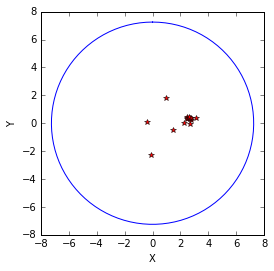

In [27]:
%matplotlib inline
theta=np.linspace(0,2*np.pi,100)
plt.plot(7.25*np.sin(theta),7.25*np.cos(theta))
plt.plot(goodfinal[:,0],goodfinal[:,1],'r*')
plt.axes().set_aspect('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [30]:
xc=np.linspace(97.5,107.5,6)
yc=np.linspace(99.5,102.5,4)
zc=np.linspace(61,67,7)
startpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((1,3))
ind=0
start=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints[ind]=np.array([i,j,k])
            [finalpoints[ind],v]=trajectory2(startpoints[ind],v0,dt)
            ind +=1
            #print (time.time()-start)/60.
end=time.time()
print end-start

405.941999912


In [31]:
goodstart=startpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
goodfinal=finalpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
print [min(goodstart[:,0]),max(goodstart[:,0])],[min(goodstart[:,1]),max(goodstart[:,1])],[min(goodstart[:,2]),max(goodstart[:,2])]
print goodfinal[:,2],goodstart

[97.5, 107.5] [100.5, 102.5] [63.0, 67.0]
[  6.35474236  11.14235222   5.10867256   5.00936053   4.53067397
  14.72163925   4.29450962   4.59299829] [[  97.5  102.5   66. ]
 [  97.5  102.5   67. ]
 [ 101.5  102.5   65. ]
 [ 103.5  102.5   65. ]
 [ 105.5  102.5   64. ]
 [ 107.5  100.5   67. ]
 [ 107.5  102.5   63. ]
 [ 107.5  102.5   64. ]]


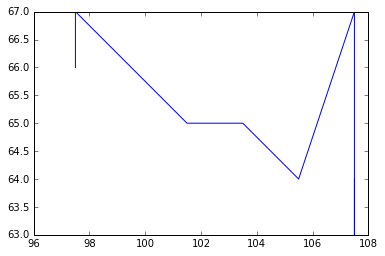

In [32]:
plt.plot(goodstart[:,0],goodstart[:,2])
plt.show()

In [33]:
xc=np.linspace(96.5,108.13)
yc=np.linspace(100,103,4)
zc=np.linspace(63,67,5)
startpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((1,3))
ind=0
start=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints[ind]=np.array([i,j,k])
            [finalpoints[ind],v]=trajectory2(startpoints[ind],v0,dt)
            ind +=1
            print (time.time()-start)/60.
end=time.time()

0.067633330822
0.103116663297
0.15076666673
0.192283332348
0.230866666635
0.248683333397
0.265799999237
0.283383333683
0.302533332507
0.338466664155
0.357049997648
0.397316666444
0.45764999787
0.502533332507
0.579066665967
0.61698333025
0.635316665967
0.652300000191
0.670416665077
0.708533330758
0.726200000445
0.743816665808
0.760633333524
0.779299998283
0.820416665077
0.847066664696
0.902483332157
0.954066665967
1.00809999704
1.12654999892
1.16423333089
1.18089999755
1.19728333155
1.2161833326
1.25001666546
1.26738333305
1.28421666622
1.30083333254
1.31838333209
1.35681666533
1.37528333267
1.3912833333
1.40745000045
1.42494999965
1.47474999825
1.49418333371
1.51614999771
1.53818333149
1.56033333143
1.61069999933
1.63415000041
1.65683333079
1.67846666574
1.69976666371
1.80339999994
1.83606666327
1.86716666619
1.91383333206
1.97105000019
2.0847333312
2.13906666438
2.1919333299
2.24413333337
2.29918333292
2.41294999917
2.46848333279
2.51211666663
2.54169999758
2.56289999882
2.59605000019

In [40]:
goodstart=startpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
goodfinal=finalpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
print [min(goodstart[:,0]),max(goodstart[:,0])],[min(goodstart[:,1]),max(goodstart[:,1])],[min(goodstart[:,2]),max(goodstart[:,2])]
print goodfinal[:,2],goodstart

[96.974693877551019, 108.13] [102.0, 103.0] [63.0, 66.0]
[ 6.50091834  6.44559725  6.43981626  6.37927645  6.35517178  6.30958881
  6.2883053   6.23836791  6.20029669  6.1629001   6.14578066  6.10469005
  6.07490649  6.0204496   6.0062647   5.97742539  5.96266212  5.96442415
  6.13700862  5.11763999  5.06588627  5.04553292  5.01182692  5.00884534
  4.97001887  4.97706372  4.95122665  4.96477942  4.95395012  4.96059391
  4.96763649  4.97091871  4.97655874  4.99764576  4.98085251  5.01961019
  5.00022789  5.03347198  4.66360146  5.0603148   4.62021215  5.11553702
  4.59406234  5.20193987  4.58663073  4.56108903  4.56710715  4.55771442
  4.55762149  4.54603098  4.54286541  4.54990785  4.54528751  4.53131819
  4.53054279  4.54794255  4.54331534  4.3636502   4.55652871  4.33195918
  4.56752766  4.31411075  4.57548242  4.30853709  4.59946432  4.29765584
  4.61617927  4.28359272  4.65085305  4.2875972 ] [[  96.97469388  103.           66.        ]
 [  97.21204082  102.           66.        ]


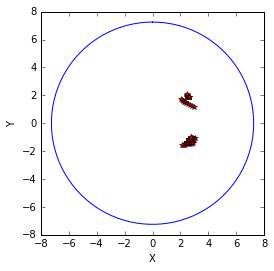

In [41]:
%matplotlib inline
theta=np.linspace(0,2*np.pi,100)
plt.plot(7.25*np.sin(theta),7.25*np.cos(theta))
plt.plot(goodfinal[:,0],goodfinal[:,1],'r*')
plt.axes().set_aspect('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [44]:
xc=np.linspace(96.,108.,13)
yc=np.linspace(102,103,4)
zc=np.linspace(63,66,8)
startpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((1,3))
ind=0
start=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints[ind]=np.array([i,j,k])
            [finalpoints[ind],v]=trajectory2(startpoints[ind],v0,dt)
            ind +=1
            #print (time.time()-start)/60.
end=time.time()
print start-end

-554.799000025


In [45]:
goodstart=startpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
goodfinal=finalpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
print [min(goodstart[:,0]),max(goodstart[:,0])],[min(goodstart[:,1]),max(goodstart[:,1])],[min(goodstart[:,2]),max(goodstart[:,2])]
print goodfinal[:,2],goodstart

[97.0, 108.0] [102.0, 103.0] [63.0, 66.0]
[ 6.51516543  6.51917915  6.50945093  6.200434    6.20164384  6.20913351
  6.18157461  5.95203807  5.95975094  5.95773841  5.98387731  5.49537548
  5.49981545  5.48688421  5.47765543  5.22981828  5.3736896   5.21434041
  5.37669009  5.20138871  5.38449174  5.41387501  5.0479989   5.71928495
  5.00687092  5.03147434  5.70293256  4.99368113  5.0302088   5.77430526
  5.04171192  4.83538813  5.08032934  4.8398822   4.82004082  5.08154626
  4.82225095  5.09271616  4.82091367  5.11244615  4.67552744  4.82832652
  5.32565826  4.66055155  4.82973848  5.31299596  4.66379716  4.82538095
  5.35059177  4.66488034  4.83511224  4.54762103  4.63250024  4.88263342
  4.53268174  4.63407218  4.88347381  4.5361652   4.63162248  4.89587253
  4.53813882  4.42001902  4.49489065  4.66651471  4.42484342  4.49631396
  4.66760376  4.42833757  4.4949493   4.6636893   4.49044543  4.33774109
  4.37009235  4.50620825  4.76443938  4.32242681  4.37162127  4.50745063
  4.76886

In [205]:
xc=np.arange(97.5-1,98.,0.3)
yc=np.array([102.5])
zc=np.arange(67-1.1,67+1,0.2)
startpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((1,3))
ind=0
start=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints[ind]=np.array([i,j,k])
            [finalpoints[ind],v]=trajectory2(startpoints[ind],v0,dt)
            ind +=1
            print (time.time()-start)/60.
end=time.time()

0.0441166679064
0.0751666665077
0.109200000763
0.143033333619
0.177550001939
0.212433334192
0.246250001589
0.28206666708
0.318183334668
0.353116667271
0.430366667112
0.465100002289
0.496433333556
0.578716667493
0.679183336099
0.729116666317
0.763599999746
0.797666668892
0.832050001621
0.866800002257
0.900800001621
0.93528333505
0.95235000054
0.969799999396
1.00423333645
1.03895000219
1.07363333305
1.10810000102
1.14238333305
1.22905000051
1.32305000226
1.433616666
1.53315000137
1.58078333537
1.61833333572
1.67421666781
1.70801666975
1.74206666946
1.77593333324
1.80990000168
1.84386666616
1.8777666688
1.91143333515
1.97541666826
2.03878333569
2.09098333518
2.19853333632
2.31026666959
2.41871666908
2.50580000083
2.55001666943
2.58420000076
2.62208333413
2.66746666829
2.74223333597


In [206]:
goodstart=startpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
goodfinal=finalpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
print [min(goodstart[:,0]),max(goodstart[:,0])],[min(goodstart[:,1]),max(goodstart[:,1])],[min(goodstart[:,2]),max(goodstart[:,2])]
print goodfinal[:,2],goodstart

[96.5, 97.699999999999989] [102.5, 102.5] [65.900000000000006, 67.900000000000034]
[  6.78631024   6.68272613   6.59157878   6.51079938  15.30666155
   6.22093326   6.45281176  15.37929083  15.49811683] [[  96.5  102.5   66.1]
 [  96.8  102.5   66.1]
 [  97.1  102.5   66.1]
 [  97.4  102.5   66.1]
 [  97.4  102.5   67.7]
 [  97.7  102.5   65.9]
 [  97.7  102.5   66.1]
 [  97.7  102.5   67.7]
 [  97.7  102.5   67.9]]


In [210]:
xc=np.arange(96.8,97.7,0.1)
yc=np.array([102.5])
zc=np.arange(65.9,67.8,0.1)
startpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((1,3))
ind=0
start=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints[ind]=np.array([i,j,k])
            [finalpoints[ind],v]=trajectory2(startpoints[ind],v0,dt)
            ind +=1
            #print (time.time()-start)/60.
end=time.time()

In [211]:
goodstart=startpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
goodfinal=finalpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
print [min(goodstart[:,0]),max(goodstart[:,0])],[min(goodstart[:,1]),max(goodstart[:,1])],[min(goodstart[:,2]),max(goodstart[:,2])]
print goodfinal[:,2],goodstart

[96.799999999999997, 97.699999999999946] [102.5, 102.5] [65.900000000000006, 67.699999999999903]
[  6.58816933   6.68272613  12.23781901  11.24869747   6.54193176
   6.65299922  12.24120432  11.28642929   6.51536131   6.6229019
  11.29560479   6.48806312   6.59157878  11.294114     6.440663
   6.57899693  11.27464204   6.41289916   6.5455223   11.25206827
  15.16397795  15.29327812   6.38394966   6.51079938  11.21249564
  15.16447631  15.30666155   6.29792301   6.35474236   6.49397684
  11.14235222  15.16699226  15.32168263   6.26948776   6.32486747
   6.47484914  11.01438996  15.19019243  15.34121782   6.22093326
   6.29448595   6.45281176  10.89021856  15.21886646  15.37929083] [[  96.8  102.5   66. ]
 [  96.8  102.5   66.1]
 [  96.8  102.5   66.8]
 [  96.8  102.5   67. ]
 [  96.9  102.5   66. ]
 [  96.9  102.5   66.1]
 [  96.9  102.5   66.8]
 [  96.9  102.5   67. ]
 [  97.   102.5   66. ]
 [  97.   102.5   66.1]
 [  97.   102.5   67. ]
 [  97.1  102.5   66. ]
 [  97.1  102.5   66.1]

In [217]:
goodstart_filter=goodstart[goodfinal[:,2]< 8]
print min(goodstart_filter[:,0]),max(goodstart_filter[:,0])
print min(goodstart_filter[:,1]),max(goodstart_filter[:,1])
print min(goodstart_filter[:,2]),max(goodstart_filter[:,2])

96.8 97.7
102.5 102.5
65.9 66.1


In [219]:
xc=np.arange(96.8,97.7,0.05)
yc=np.array([102.5])
zc=np.arange(65.9,66.1,0.05)
startpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
finalpoints=np.zeros((len(xc)*len(yc)*len(zc),3))
v=np.zeros((1,3))
ind=0
start=time.time()
for i in xc:
    for j in yc:
        for k in zc:
            startpoints[ind]=np.array([i,j,k])
            [finalpoints[ind],v]=trajectory2(startpoints[ind],v0,dt)
            ind +=1
            #print (time.time()-start)/60.
end=time.time()

In [220]:
goodstart=startpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
goodfinal=finalpoints[np.linalg.norm(finalpoints[:,:2],axis=1) < 3.25]
print [min(goodstart[:,0]),max(goodstart[:,0])],[min(goodstart[:,1]),max(goodstart[:,1])],[min(goodstart[:,2]),max(goodstart[:,2])]
print goodfinal[:,2],goodstart

[96.799999999999997, 97.699999999999946] [102.5, 102.5] [65.900000000000006, 66.049999999999997]
[ 6.58816933  6.62590767  6.56501267  6.60258271  6.54193176  6.59913706
  6.53867709  6.57557018  6.51536131  6.55167399  6.46501263  6.4916566
  6.54736537  6.44139897  6.48806312  6.523325    6.43759678  6.46460115
  6.5186818   6.4144299   6.440663    6.49394094  6.39061705  6.43651921
  6.48943735  6.38659793  6.41289916  6.46444471  6.36290765  6.40853296
  6.45927985  6.3589155   6.38394966  6.43429439  6.30208431  6.33481858
  6.37952595  6.42896319  6.29792301  6.31056724  6.35474236  6.40350936
  6.27409838  6.30637479  6.3496277   6.39829139  6.26948776  6.28192076
  6.32486747  6.37262701  6.24527064  6.27723679  6.31976178  6.36739701
  6.22093326  6.25288857  6.29448595  6.34203187] [[  96.8   102.5    66.  ]
 [  96.8   102.5    66.05]
 [  96.85  102.5    66.  ]
 [  96.85  102.5    66.05]
 [  96.9   102.5    66.  ]
 [  96.9   102.5    66.05]
 [  96.95  102.5    66.  ]
 [  96.9

In [230]:
goodstart_filter=goodstart[np.abs(goodfinal[:,2] - 6.6 )< 0.01]
print min(goodstart_filter[:,0]),max(goodstart_filter[:,0])
print min(goodstart_filter[:,1]),max(goodstart_filter[:,1])
print min(goodstart_filter[:,2]),max(goodstart_filter[:,2])

96.85 96.9
102.5 102.5
66.05 66.05


**Choose starting point at (96.9,102.5,66.05)**

### Arrival position sensitiveness to initial position's offset

In [16]:
#[r,v,t]=trajectory(r0,v0,dt)
r0=np.array([96.9,102.5,66.05])
v0=np.array([0,0,0])
t1=time.time()
[r,v]=trajectory2(r0,v0,dt)
t2=time.time()
print r

[2.7964238152028678, -0.11293771290986854, 6.5991370585118476]


In [256]:
d=np.arange(-5,5,0.2)
xd=np.zeros((len(d),4))
for k in range(len(d)):
    rr=np.array([96.9+d[k],102.5,66.05])
    [r,v]=trajectory2(rr,v0,dt)
    xd[k,0]=rr[0]
    xd[k,1]=r[0]
    xd[k,2]=r[1]
    xd[k,3]=r[2]
    
    #print rr,r
    

In [257]:
d=np.arange(-5,5,0.2)
yd=np.zeros((len(d),4))
for k in range(len(d)):
    rr=np.array([96.9,102.5+d[k],66.05])
    [r,v]=trajectory2(rr,v0,dt)
    yd[k,0]=rr[1]
    yd[k,1]=r[0]
    yd[k,2]=r[1]
    yd[k,3]=r[2]
    
    #print rr,r

In [258]:
d=np.arange(-5,5,0.2)
zd=np.zeros((len(d),4))
for k in range(len(d)):
    rr=np.array([96.9,102.5,66.05+d[k]])
    [r,v]=trajectory2(rr,v0,dt)
    zd[k,0]=rr[2]
    zd[k,1]=r[0]
    zd[k,2]=r[1]
    zd[k,3]=r[2]
    
    #print rr,r
    

Final x' position of different initial position in x,y,z axes

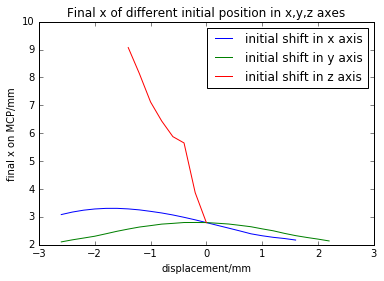

In [259]:
plt.plot(d[12:-16],xd[12:-16,1],label='initial shift in x axis')
plt.plot(d[12:-13],yd[12:-13,1],label='initial shift in y axis')
plt.plot(d[18:-24],zd[18:-24,1],label='initial shift in z axis')
plt.legend(loc='best')
plt.xlabel("displacement/mm")
plt.ylabel("final x on MCP/mm")
plt.title("Final x of different initial position in x,y,z axes")

Final y' position of different initial position in x,y,z axes

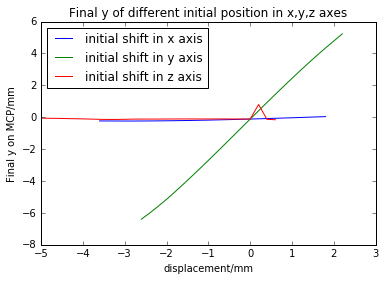

In [260]:
plt.plot(d[7:-15],xd[7:-15,2],label='initial shift in x axis')
plt.plot(d[12:-13],yd[12:-13,2],label='initial shift in y axis')
plt.plot(d[:-21],zd[:-21,2],label='initial shift in z axis')
plt.legend(loc='best')
plt.xlabel("displacement/mm")
plt.ylabel("Final y on MCP/mm")
plt.title("Final y of different initial position in x,y,z axes")

TOFs of different initial position in x,y,z axes

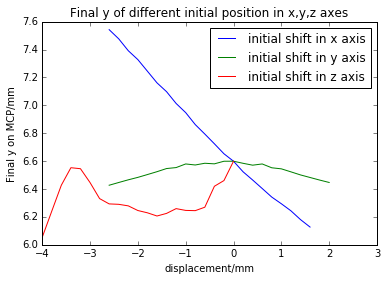

In [261]:
plt.plot(d[12:-16],xd[12:-16,3],label='initial shift in x axis')
plt.plot(d[12:-14],yd[12:-14,3],label='initial shift in y axis')
plt.plot(d[5:-24],zd[5:-24,3],label='initial shift in z axis')
plt.legend(loc='best')
plt.xlabel("displacement/mm")
plt.ylabel("Final y on MCP/mm")
plt.title("Final y of different initial position in x,y,z axes")

Iterate in space

In [85]:
n=(np.arange(9)-2)*5
trajectories=list()
m=0
for i in n:
    for j in n:
        for k in n:
            rd=[i+r0[0],j+r0[1],k+r0[2]]
            
            [ri,v,t]=trajectory(rd,v0,dt)
            trajectories.append(ri)

In [86]:
#import simion simulated single ion trajectory
simion_trajectory=pd.read_csv('./flying ion test v2.csv',header=None)

simion_trajectory.columns=['TOF','x','y','z','vx','vy','vz']
sim_x=simion_trajectory.x.values
sim_y=simion_trajectory.y.values
sim_z=simion_trajectory.z.values

<IPython.core.display.Javascript object>


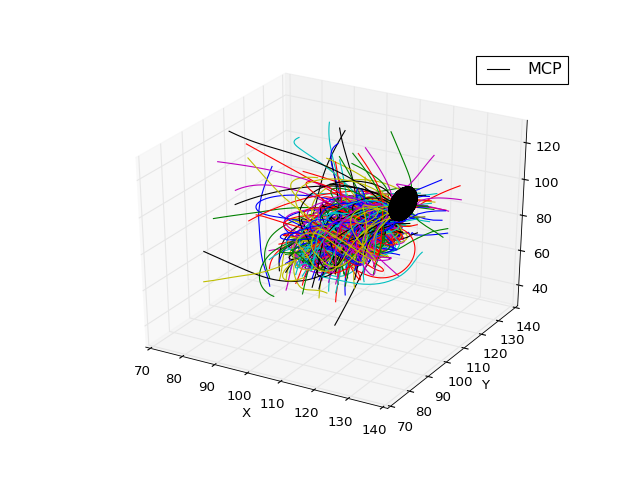

In [87]:
%matplotlib notebook
trj3d=plt.figure()
ax=trj3d.add_subplot(111,projection='3d')
for i in trajectories:
    ax.plot(i[:,0],i[:,1],i[:,2])

#ax.plot(sim_x,sim_y,sim_z,label='simion')
ax.plot(MCP[:,0],MCP[:,1],MCP[:,2],label='MCP')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc='best')
plt.show()

In [88]:
endpoints=np.array([i[-1] for i in trajectories])
#goodpoints=[i for i in len(endpoints) if np.linalg.norm(endpoints[i]-center)<7.25]

In [182]:
import time

In [102]:
import time
start=time.time()
[f10,v10]=trajectory2(r0,v0,dt)
end=time.time()
print end-start

1.84500002861


In [108]:
(end-start)*800/60

24.600000381469727

#### Change deflection ring 1 voltage from 0.3 to 10

In [14]:
#electrode_set_potentials=[187.,187.,-1.74,-278.,-0.114,-1900.,0.,3.97,-1.74,-278.,187.,187.,0.3,-278.,0.,0.,0.,0.318,0.307]
electrode_set_potentials=[195.,195.,-145.,-232.,-0.114,-1900.,0.,4.,0.3,-232.,195.,195.,-145.,-232.,0.,0.,0.,0.318,0.307];
#vd1=np.linspace(-14.,56.,21)
vd1= -232. + np.linspace(-290,60,21)
print vd1

[-522.  -504.5 -487.  -469.5 -452.  -434.5 -417.  -399.5 -382.  -364.5
 -347.  -329.5 -312.  -294.5 -277.  -259.5 -242.  -224.5 -207.  -189.5
 -172. ]


In [15]:
pvd=np.zeros((len(vd1),3))
v=np.zeros((1,3))
r0=np.array([96.9,102.5,66.05])
#r0=np.array([97.5,102.5,66.])
#r0=np.array([102.5,102.5,65.])
v0=np.array([0,0,0])
for i in range(len(vd1)):
    electrode_set_potentials[9]=vd1[i]
    potentials=np.zeros((len(x),len(y),len(z)))
    for k in range(19):
        electroden=f["Potential Arrays/electrode"+str(k+1)].value
        potentials+=electrode_set_potentials[k]*electroden/10000.
    p_interpolation=rgi((x,y,z),potentials)
    [pvd[i,:],v]=trajectory2(r0,v0,dt)
    #print np.linalg.norm(hope[i,:2]),hope[i,2]
    
electrode_set_potentials=[195.,195.,-145.,-232.,-0.114,-1900.,0.,4.,0.3,-232.,195.,195.,-145.,-232.,0.,0.,0.,0.318,0.307];

In [16]:
print "x:", pvd[:,0]
print "y:", pvd[:,1]

x: [ -6.75043444  -6.90138584  -2.16063573  -1.66832685  -1.44202904
  -1.34761196  -1.23204288  -1.03303134  -0.81953543  -0.56767337
  -0.30738132  -0.05403863  41.05650341  48.83118056   2.00293614
   2.24797176   2.54676797   3.01283324   3.57837173   4.22371436
   5.55760474]
y: [ 14.90602657   2.26122466   0.1991808    0.17830578   0.1623192
   0.1473962    0.13201589   0.11593566   0.09885365   0.080397
   0.06065771   0.03896678  -0.96909606  -0.76819465  -0.0341073
  -0.0613198   -0.0929249   -0.12836764  -0.16934194  -0.21762883
  -0.24877908]


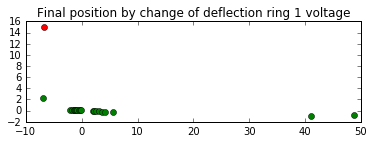

In [17]:
%matplotlib inline
plt.plot(pvd[0,0],pvd[0,1],'ro')
plt.plot(pvd[1:,0],pvd[1:,1],'go')
plt.title("Final position by change of deflection ring 1 voltage")
plt.axes().set_aspect('equal')
plt.show()

In [18]:
xfit=np.polyfit(vd1,pvd[:,0],1)
xfitp=np.poly1d(xfit)

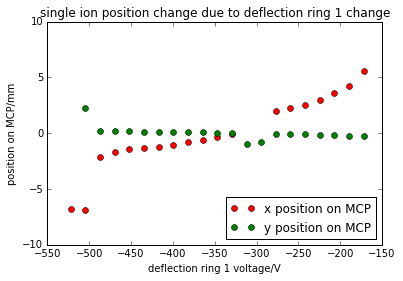

In [21]:
plt.figure()
plt.plot(vd1,pvd[:,0],'ro',label='x position on MCP')
plt.plot(vd1,pvd[:,1],'go',label='y position on MCP')
#plt.plot(vd1,xfitp(vd1))
#plt.plot(vd1,[5.5 for i in range(len(vd1))])
#plt.plot(vd1,[-5.5 for i in range(len(vd1))])
plt.title("single ion position change due to deflection ring 1 change")
plt.xlabel("deflection ring 1 voltage/V")
plt.ylabel("position on MCP/mm")
plt.legend(loc='best')
plt.ylim([-10,10])
plt.show()

In [125]:
xfit

array([  0.04382898,  19.43597611])

In [126]:
v0=(0.-xfit[1])/xfit[0]
v1=(7.25-xfit[1])/xfit[0]
v2=(-7.25-xfit[1])/xfit[0]
v0,v1,v2

(-443.45039063776733, -278.03470409457651, -608.86607718095809)

In [127]:
pvd[:,2]

array([ 12.26904598,  11.27144044,   5.11208319,   5.118841  ,
         5.17524478,   5.25528225,   5.34469506,   5.44468591,
         5.55579461,   5.67365863,   5.81628514,   5.98458363,
         9.13662458,   8.28264247,   6.1482887 ,   6.28408401,
         6.4769427 ,   6.68465795,   6.92560296,   7.20855999,   7.27324862])